## Voiceprint Verification Model Overview

- Load raw audio samples of approved phrases.
- Apply audio augmentations (pitch shift, time stretch, noise) to increase data variety.
- Extract features such as MFCCs, spectral roll-off, and energy.
- Train a classifier (e.g., Random Forest) on extracted audio features.
- Verify user identity by matching voiceprint from new audio samples.


In [1]:
# Import core audio processing and visualization libraries 
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio, display
import os
import random


### Audio Visualization Examples
Below are waveform and spectrogram plots for selected audio samples. The full dataset of 8 audios is 
processed automatically during feature extraction.


In [25]:
# Function to load and play an audio file 
def load_and_play_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    print(f"Loaded '{file_path}' (Sample Rate: {sr} Hz)")
    display(Audio(y, rate=sr))
    return y, sr

# Example usage (replace with your actual path) 
y, sr = load_and_play_audio('../data/raw/audio/member 1/Yes_approve.opus')
y, sr = load_and_play_audio('../data/raw/audio/member 2/Yes_approve.opus')

y, sf = load_and_play_audio('../data/raw/audio/member 3/Confirm_transaction.opus')
y, sf = load_and_play_audio('../data/raw/audio/member 4/Confirm_transaction.opus')

Loaded '../data/raw/audio/member 1/Yes_approve.opus' (Sample Rate: 16000 Hz)


Loaded '../data/raw/audio/member 2/Yes_approve.opus' (Sample Rate: 16000 Hz)


Loaded '../data/raw/audio/member 3/Confirm_transaction.opus' (Sample Rate: 16000 Hz)


Loaded '../data/raw/audio/member 4/Confirm_transaction.opus' (Sample Rate: 16000 Hz)


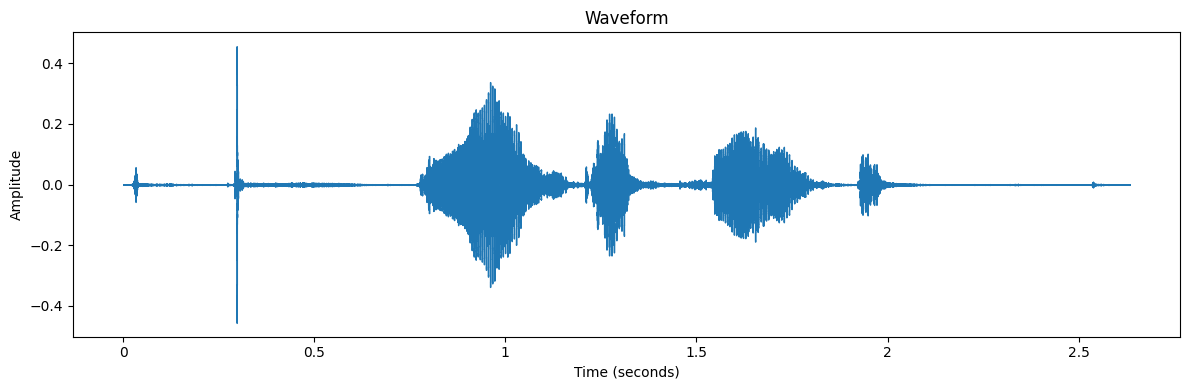

In [13]:
# Function to visualize the raw waveform of an audio file 
def plot_waveform(y, sr, title="Waveform"):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

#  Example usage 
plot_waveform(y, sr)


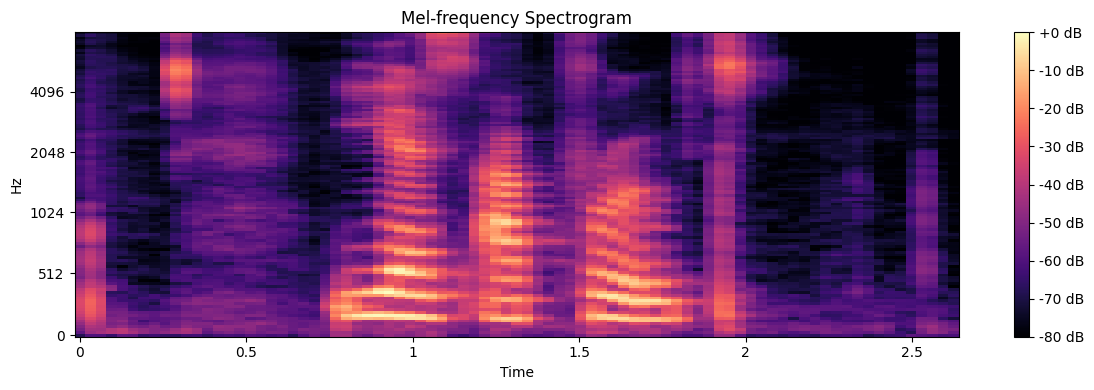

In [ ]:
# Function to visualize the frequency energy using a Mel-spectrogram 
def plot_mel_spectrogram(y, sr, title="Mel-frequency Spectrogram"):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage 
plot_mel_spectrogram(y, sr)


Spectral Rolloff Mean: 4432.79
Energy: 0.00136


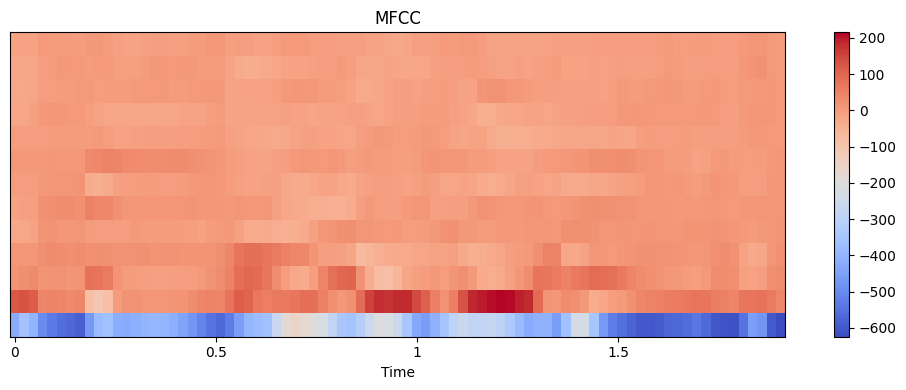

In [ ]:
# Function to extract key audio features (MFCCs, rolloff, energy) 
def extract_and_display_features(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    energy = np.sum(y ** 2) / len(y)

    print(f"Spectral Rolloff Mean: {np.mean(spectral_rolloff):.2f}")
    print(f"Energy: {energy:.5f}")

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title("MFCCs (Mel-Frequency Cepstral Coefficients)")
    plt.tight_layout()
    plt.show()

# Example usage
extract_and_display_features(y, sr)


Visualizing Confirm_transaction.opus


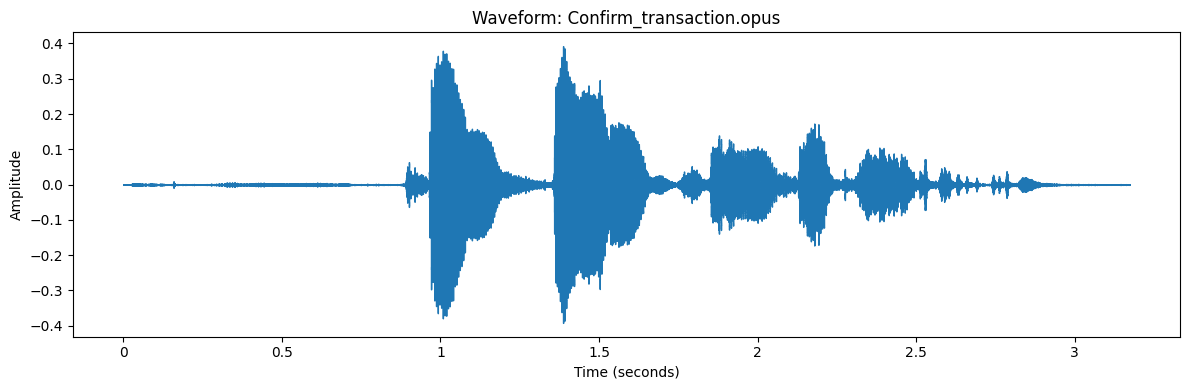

Visualizing Yes_approve.opus


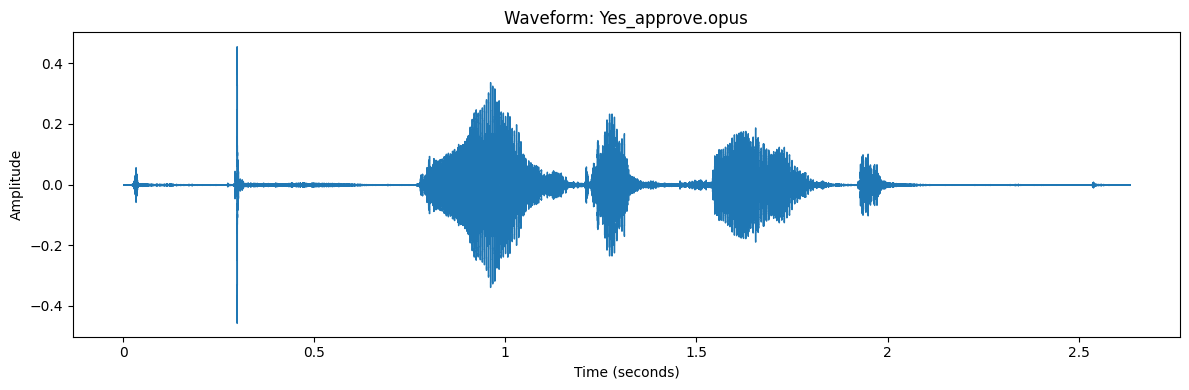

In [ ]:
# Function to visualize all audio files in a directory 
def visualize_audio_folder(audio_dir):
    for file in os.listdir(audio_dir):
        if file.lower().endswith(('.wav', '.opus')):
            print(f"🎧 Visualizing: {file}")
            y, sr = librosa.load(os.path.join(audio_dir, file), sr=None)
            plot_waveform(y, sr, title=f"Waveform: {file}")
            plot_mel_spectrogram(y, sr, title=f"Spectrogram: {file}")

# --- Example usage ---
visualize_audio_folder('../data/raw/audio/')


In [ ]:
# Function to apply 2+ augmentations and extract features from multiple audios
def extract_features(y, sr, label):
    """Extracts MFCC, rolloff, and energy features for a single audio."""
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    energy = np.sum(y ** 2) / len(y)
    feature_dict = {f"mfcc_{i+1}": mf for i, mf in enumerate(mfccs)}
    feature_dict.update({"rolloff": rolloff, "energy": energy, "label": label})
    return feature_dict

def augment_audio(y, sr):
    """Apply multiple augmentations: time stretch, pitch shift, background noise."""
    augmentations = []
    # 1. Pitch Shift
    augmentations.append(librosa.effects.pitch_shift(y, sr, n_steps=random.choice([-2, 2])))
    # 2. Time Stretch
    augmentations.append(librosa.effects.time_stretch(y, rate=random.choice([0.8, 1.2])))
    # 3. Add background noise
    noise = np.random.randn(len(y))
    augmentations.append(y + 0.005 * noise)
    return augmentations

# Extract features for all audios and save 
audio_dir = '../data/raw/audio/'
all_features = []

for file in os.listdir(audio_dir):
    if file.lower().endswith(('.wav', '.opus')):
        label = file.split('_')[0]  # Speaker label from filename
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=None)
        # Original audio features
        all_features.append(extract_features(y, sr, label + "_original"))
        # Augmented versions
        for i, aug in enumerate(augment_audio(y, sr)):
            all_features.append(extract_features(aug, sr, f"{label}_aug{i+1}"))

#  Save all features into a CSV file 
df = pd.DataFrame(all_features)
df.to_csv("audio_features.csv", index=False)
print("✅ Features extracted and saved to 'audio_features.csv'")
df.head()


In [ ]:
#  Import model libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

#  Load extracted features 
df = pd.read_csv("audio_features.csv")

#  Split into features (X) and target (y) 
X = df.drop(columns=["label"])
y = df["label"]

#  Encode speaker labels numerically 
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#  Standardize features for consistency 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Split data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

#  Train Random Forest classifier 
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#  Evaluate model performance 
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {acc * 100:.2f}%\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

#  Save model and encoders for later verification 
joblib.dump(model, "voice_model.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
print("💾 Model, label encoder, and scaler saved successfully.")


In [ ]:
# Function to verify a new voice sample using the trained model 
def verify_voice(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = extract_features(y, sr, label="test")
    X = np.array([list(features.values())[:-1]])  # Exclude label
    X_scaled = scaler.transform(X)
    pred = model.predict(X_scaled)
    predicted_label = le.inverse_transform(pred)[0]
    print(f"🎤 Predicted Speaker: {predicted_label}")

#  Example test using one of your 8 audios 
verify_voice('../data/raw/audio/Yes_approve.opus')
